In [65]:
# Imports

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter  
import calendar
from dateutil import relativedelta
import operator
import os
import random
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)
pd.set_option('display.max_colwidth', None)
%matplotlib inline

In [370]:
detail = pd.read_csv('CS_DETAIL_RETAIL.csv',converters={'CIF_ID':str})
non_loan = pd.read_csv('CS_NON_LOAN_ACC_RETAIL_2_2_1.csv',converters={'CIF_ID':str})
loan = pd.read_csv('CS_LOAN_ACC_RETAIL_2_2_1.csv',converters={'CIF_ID':str})
trans = pd.read_csv('CS_TRANS_RETAIL_2.csv',converters={'CIF_ID':str})
eod = pd.read_csv('CS_EOD_RETAIL.csv',converters={'CIF_ID':str})
otg = pd.read_csv('CS_OTG_RETAIL.csv',converters={'CIF_ID':str})

In [371]:
loan.columns

Index(['CIF_ID', 'LOAN_ACCOUNTS'], dtype='object')

In [67]:
dfs = [detail, non_loan, loan, trans, eod, otg ]

for i, df in enumerate(dfs, start=1):
    print(f"DataFrame {i} - Shape: {df.shape}, Unique IDs: {df['CIF_ID'].nunique()}")

DataFrame 1 - Shape: (852, 22), Unique IDs: 537
DataFrame 2 - Shape: (681, 2), Unique IDs: 681
DataFrame 3 - Shape: (582, 2), Unique IDs: 582
DataFrame 4 - Shape: (319562, 8), Unique IDs: 533
DataFrame 5 - Shape: (9297, 3), Unique IDs: 679
DataFrame 6 - Shape: (6671, 6), Unique IDs: 686


In [68]:
columns_to_drop = ['CUSTOMERINCOME', 'SECTOR', 'SUBSECTOR', 'SECURED_FLG', 'PHYSICALADDRESS']
detail.drop(columns=columns_to_drop, inplace=True)

In [69]:
# detail['FLOW_AMT'] == 0 are new loans and have not paid instalments on their loans yet 
detail = detail[~((detail['FLOW_ID'] == 'INDEM') & (detail['FLOW_AMT'] == 0))]


In [70]:
# Default on a loan has been described as 60 days past instalment payment date
detail['DEFAULT_STATUS'] = (detail['DPD_CNTR'] >= 60).astype(int)
default_status_counts = detail['DEFAULT_STATUS'].value_counts()

print("Number of 0's (DPD_CNTR < 60):", default_status_counts[0])
print("Number of 1's (DPD_CNTR >= 60):", default_status_counts[1])

Number of 0's (DPD_CNTR < 60): 597
Number of 1's (DPD_CNTR >= 60): 62


## TRANSACTIONS

In [71]:
detail.drop('ACID', inplace=True,axis=1)
trans.drop('ACID',inplace=True,axis=1)

In [72]:
df_detail_trans = pd.merge(detail,trans,on='CIF_ID', how='left')

In [73]:
df_detail_trans['CIF_ID'].nunique()

537

In [74]:
# df_detail_trans.drop(['SEGMENTATION_CLASS', 'SCHM_CODE'], axis=1, inplace=True)

In [75]:
detail.SEGMENTATION_CLASS.value_counts()

BL03    513
BL05    146
Name: SEGMENTATION_CLASS, dtype: int64

In [76]:
schm_code_counts = detail['SCHM_CODE'].value_counts()


In [77]:
import plotly.express as px
fig = px.bar(schm_code_counts, x=schm_code_counts.index, y=schm_code_counts.values, 
             labels={'SCHM_CODE': 'Scheme Code', 'count': 'Count'},
             title='Value Counts of Scheme Codes')

fig.show()

In [78]:
schm_code_counts.values

array([154, 148, 128, 111,  57,  48,   5,   5,   2,   1])

In [79]:
df_detail_trans['TRAN_DATE'] = pd.to_datetime(df_detail_trans['TRAN_DATE'])
df_detail_trans['DISB_DATE'] = pd.to_datetime(df_detail_trans['DISB_DATE'])
df_detail_trans['DISB_DATE_3WK'] = pd.to_datetime(df_detail_trans['DISB_DATE_3WK'])
df_detail_trans['DISB_DATE'] = pd.to_datetime(df_detail_trans['DISB_DATE'])

In [80]:
df_detail_trans['TRAN_WEEK'] = df_detail_trans['TRAN_DATE'].dt.isocalendar().week

In [81]:
filtered_trans = df_detail_trans[
    (df_detail_trans['TRAN_DATE'] >= df_detail_trans['DISB_DATE']) &
    (df_detail_trans['TRAN_DATE'] <= df_detail_trans['DISB_DATE_3WK'])
]

In [82]:
filtered_trans['TRAN_DATE'].max()

Timestamp('2023-07-21 00:00:00')

In [83]:
df_detail_trans['TRAN_DATE'].max()

Timestamp('2023-07-21 00:00:00')

In [84]:
debit_trans = filtered_trans[filtered_trans['PART_TRAN_TYPE'] == 'D']
credit_trans = filtered_trans[filtered_trans['PART_TRAN_TYPE'] == 'C']


In [85]:
credit_trans['UNIQUE_ID'] = [x + '_' + y for x,y in zip(credit_trans['CIF_ID'],credit_trans['TRAN_ID'])]
debit_trans['UNIQUE_ID'] = [x + '_' + y for x,y in zip(debit_trans['CIF_ID'],debit_trans['TRAN_ID'])]
credit_trans = credit_trans[~credit_trans['UNIQUE_ID'].isin(debit_trans['UNIQUE_ID'])]

In [86]:
grouped_debits = debit_trans.groupby(['CIF_ID', 'TRAN_WEEK']).size().reset_index(name='DEBIT_COUNT')
grouped_credits = credit_trans.groupby(['CIF_ID', 'TRAN_WEEK']).size().reset_index(name='CREDIT_COUNT')

In [88]:
merged_df = grouped_debits.merge(grouped_credits, on=['CIF_ID', 'TRAN_WEEK'], how='left').fillna(0)

In [89]:
merged_df.sample()

,CIF_ID,TRAN_WEEK,DEBIT_COUNT,CREDIT_COUNT
411,0183670,37,5,0.0


In [90]:
merged_df['WEEKLY_DEBIT_CREDIT_COUNT_RATIO'] = merged_df['DEBIT_COUNT'] / merged_df['CREDIT_COUNT'].replace(0, 1)


In [91]:
merged_df.sample()

,CIF_ID,TRAN_WEEK,DEBIT_COUNT,CREDIT_COUNT,WEEKLY_DEBIT_CREDIT_COUNT_RATIO
720,0373061,6,4,0.0,4.0


In [92]:
summary_df = merged_df.groupby('CIF_ID')['WEEKLY_DEBIT_CREDIT_COUNT_RATIO'].agg(['mean', 'median']).reset_index()
summary_df.rename(columns={'mean': 'AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO', 'median': 'MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO'}, inplace=True)


In [99]:
summary_df.sample()

,CIF_ID,AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO
276,0380011,3.25,4.0


In [100]:
trans_cr = trans[trans['PART_TRAN_TYPE'] == 'C']
trans_dr = trans[trans['PART_TRAN_TYPE'] == 'D']

In [101]:
trans_cr['UNIQUE_ID'] = [x + '_' + y for x,y in zip(trans_cr['CIF_ID'],trans_cr['TRAN_ID'])]
trans_dr['UNIQUE_ID'] = [x + '_' + y for x,y in zip(trans_dr['CIF_ID'],trans_dr['TRAN_ID'])]
trans_cr = trans_cr[~trans_cr['UNIQUE_ID'].isin(trans_dr['UNIQUE_ID'])]

In [102]:
trans_cr = pd.merge(trans_cr,detail[['CIF_ID','DISB_DATE_3WK','DISB_DATE']],
                   how='left',on='CIF_ID')
trans_dr = pd.merge(trans_dr,detail[['CIF_ID','DISB_DATE_3WK','DISB_DATE']],
                   how='left',on='CIF_ID')

In [103]:
trans_dr.sample()

,CIF_ID,TRAN_ID,PART_TRAN_TYPE,TRAN_CRNCY_CODE,TRAN_DATE,ORIGINAL_AMOUNT,CONVERTED_AMOUNT,UNIQUE_ID,DISB_DATE_3WK,DISB_DATE
338066,0371732,017126,D,KES,19-DEC-22,82.5,82.5,0371732_ 017126,02-FEB-23,12-JAN-23


In [104]:
trans_cr['TRAN_DATE'] = pd.to_datetime(trans_cr['TRAN_DATE'])
trans_cr['DISB_DATE_3WK'] = pd.to_datetime(trans_cr['DISB_DATE_3WK'])
trans_cr['DISB_DATE'] = pd.to_datetime(trans_cr['DISB_DATE'])
trans_dr['DISB_DATE_3WK'] = pd.to_datetime(trans_dr['DISB_DATE_3WK'])
trans_dr['TRAN_DATE'] = pd.to_datetime(trans_dr['TRAN_DATE'])
trans_dr['DISB_DATE'] = pd.to_datetime(trans_dr['DISB_DATE'])

In [105]:
trans_cr_unique = trans_cr[['CIF_ID','DISB_DATE_3WK','DISB_DATE']]
trans_cr_unique.drop_duplicates(keep='first',inplace=True)
trans_dr_unique = trans_dr[['CIF_ID','DISB_DATE_3WK','DISB_DATE']]
trans_dr_unique.drop_duplicates(keep='first',inplace=True)

In [106]:
trans_cr_unique.shape, trans_dr_unique.shape

((653, 3), (654, 3))

## CREDIT AGGREGATIONS

In [107]:
def in_3_week_period(row, DISB_DATE, DISB_DATE_3WK):
    return row['TRAN_DATE'] >= DISB_DATE and row['TRAN_DATE'] <= DISB_DATE_3WK

filtered_dfs = []
for _, unique_row in trans_cr_unique.iterrows():
    filtered_df = trans_cr[trans_cr['CIF_ID'] == unique_row['CIF_ID']]
    filtered_df = filtered_df[filtered_df.apply(in_3_week_period, args=(unique_row['DISB_DATE'], unique_row['DISB_DATE_3WK']), axis=1)]
    filtered_dfs.append(filtered_df)
    
trans_cr_filtered = pd.concat(filtered_dfs)


trans_cr_filtered['TRAN_WEEK'] = trans_cr_filtered['TRAN_DATE'].dt.strftime('%U')

grouped_cr_weekly = trans_cr_filtered.groupby(['CIF_ID', 'TRAN_WEEK']).agg({
    'CONVERTED_AMOUNT': ['sum', 'count']
}).reset_index()
grouped_cr_weekly.columns = ['_'.join(col).strip() for col in grouped_cr_weekly.columns.values]
grouped_cr_weekly.rename(columns={'CIF_ID_': 'CIF_ID', 'TRAN_WEEK_': 'TRAN_WEEK'}, inplace=True)

grouped_cr_mean_median = grouped_cr_weekly.groupby('CIF_ID').agg({
    'CONVERTED_AMOUNT_sum': ['mean', 'median'],
    'CONVERTED_AMOUNT_count': 'mean'
}).reset_index()
grouped_cr_mean_median.columns = ['_'.join(col).strip() for col in grouped_cr_mean_median.columns.values]

grouped_cr_mean_median.rename(columns={
    'CIF_ID_': 'CIF_ID',
    'CONVERTED_AMOUNT_sum_mean': 'avg_cred_amt_3_weeks',
    'CONVERTED_AMOUNT_sum_median': 'median_cred_amt_3_weeks',
    'CONVERTED_AMOUNT_count_mean': 'avg_weekly_cred_count_3_weeks'
}, inplace=True)


In [108]:
grouped_cr_mean_median.sample()

,CIF_ID,avg_cred_amt_3_weeks,median_cred_amt_3_weeks,avg_weekly_cred_count_3_weeks
513,0406690,148118.5200000000186265,148118.5200000000186265,1.5


In [109]:
grouped_cr_min_max = trans_cr.groupby('CIF_ID').agg({'CONVERTED_AMOUNT':['min','max']}).reset_index()
grouped_cr_min_max.columns = [x1+'_'+x2 for x1,x2 in grouped_cr_min_max.columns]
grouped_cr_min_max.rename(columns = {'CIF_ID_':'CIF_ID',
                            'CONVERTED_AMOUNT_min': 'min_cred_amt_3_weeks',
                            'CONVERTED_AMOUNT_max': 'max_cred_amt_3_weeks'},inplace=True)

In [110]:
trans_cr_unique = pd.merge(trans_cr_unique,grouped_cr_mean_median,how='left',on='CIF_ID')

In [111]:
trans_cr_unique = pd.merge(trans_cr_unique,grouped_cr_min_max,how='left',on='CIF_ID')

In [112]:
trans_cr_unique.sample()

,CIF_ID,DISB_DATE_3WK,DISB_DATE,avg_cred_amt_3_weeks,median_cred_amt_3_weeks,avg_weekly_cred_count_3_weeks,min_cred_amt_3_weeks,max_cred_amt_3_weeks
322,0377735,2023-06-14,2023-05-24,4237413.3333333330228925,5351240.0,42.6666666666666643,100.0,773500.0


In [113]:
del trans_cr_unique['DISB_DATE_3WK']
del trans_cr_unique['DISB_DATE']

## DEBIT AGGREGATIONS

In [114]:
def in_3_week_period(row, DISB_DATE, DISB_DATE_3WK):
    return row['TRAN_DATE'] >= DISB_DATE and row['TRAN_DATE'] <= DISB_DATE_3WK

filtered_dfs = []
for _, unique_row in trans_dr_unique.iterrows():
    filtered_df = trans_dr[trans_dr['CIF_ID'] == unique_row['CIF_ID']]
    filtered_df = filtered_df[filtered_df.apply(in_3_week_period, args=(unique_row['DISB_DATE'], unique_row['DISB_DATE_3WK']), axis=1)]
    filtered_dfs.append(filtered_df)
    
trans_dr_filtered = pd.concat(filtered_dfs)

trans_dr_filtered['TRAN_WEEK'] = trans_dr_filtered['TRAN_DATE'].dt.strftime('%U')

grouped_dr_weekly = trans_dr_filtered.groupby(['CIF_ID', 'TRAN_WEEK']).agg({
    'CONVERTED_AMOUNT': ['sum', 'count']
}).reset_index()
grouped_dr_weekly.columns = ['_'.join(col).strip() for col in grouped_dr_weekly.columns.values]
grouped_dr_weekly.rename(columns={'CIF_ID_': 'CIF_ID', 'TRAN_WEEK_': 'TRAN_WEEK'}, inplace=True)


grouped_dr_mean_median = grouped_dr_weekly.groupby('CIF_ID').agg({
    'CONVERTED_AMOUNT_sum': ['mean', 'median'],
    'CONVERTED_AMOUNT_count': 'mean'
}).reset_index()
grouped_dr_mean_median.columns = ['_'.join(col).strip() for col in grouped_dr_mean_median.columns.values]

grouped_dr_mean_median.rename(columns={
    'CIF_ID_': 'CIF_ID',
    'CONVERTED_AMOUNT_sum_mean': 'avg_debit_amt_3_weeks',
    'CONVERTED_AMOUNT_sum_median': 'median_debit_amt_3_weeks',
    'CONVERTED_AMOUNT_count_mean': 'avg_weekly_debit_count_3_weeks'
}, inplace=True)

In [115]:
grouped_dr_min_max = trans_dr.groupby('CIF_ID').agg({'CONVERTED_AMOUNT':['min','max']}).reset_index()
grouped_dr_min_max.columns = [x1+'_'+x2 for x1,x2 in grouped_dr_min_max.columns]
grouped_dr_min_max.rename(columns = {'CIF_ID_':'CIF_ID',
                            'CONVERTED_AMOUNT_min': 'min_debit_amt_3_weeks',
                            'CONVERTED_AMOUNT_max': 'max_debit_amt_3_weeks'},inplace=True)

In [116]:
trans_dr_unique = pd.merge(trans_dr_unique,grouped_dr_mean_median,how='left',on='CIF_ID')

In [117]:
trans_dr_unique = pd.merge(trans_dr_unique,grouped_dr_min_max,how='left',on='CIF_ID')

In [118]:
del trans_dr_unique['DISB_DATE_3WK']
del trans_dr_unique['DISB_DATE']

## End of Day Balances(EOD)

In [119]:
eod.columns

Index(['CIF_ID', 'EOD_DATE', 'TRAN_DATE_BAL'], dtype='object')

In [120]:
eod['EOD_DATE'] = pd.to_datetime(eod['EOD_DATE'])

eod['TRAN_WEEK'] = eod['EOD_DATE'].dt.strftime('%U')

grouped_eod_weekly = eod.groupby(['CIF_ID', 'TRAN_WEEK']).agg({'TRAN_DATE_BAL': ['mean', 'median']}).reset_index()
grouped_eod_weekly.columns = ['_'.join(col).strip() for col in grouped_eod_weekly.columns.values]
grouped_eod_weekly.rename(columns={'CIF_ID_': 'CIF_ID', 'TRAN_WEEK_': 'TRAN_WEEK'}, inplace=True)

grouped_eod_mean_median = grouped_eod_weekly.groupby('CIF_ID').agg({
    'TRAN_DATE_BAL_mean': ['mean', 'median']
}).reset_index()
grouped_eod_mean_median.columns = ['_'.join(col).strip() for col in grouped_eod_mean_median.columns.values]

grouped_eod_mean_median.rename(columns={
    'CIF_ID_': 'CIF_ID',
    'TRAN_DATE_BAL_mean_mean': 'avg_eod_bal_3_weeks',
    'TRAN_DATE_BAL_mean_median': 'median_eod_bal_3_weeks'
}, inplace=True)

In [121]:
trans_cr_unique = pd.merge(trans_cr_unique, grouped_eod_mean_median, on='CIF_ID', how='left')

In [122]:
trans_cr_dr_eod = pd.merge(trans_dr_unique,trans_cr_unique,how='left', on = 'CIF_ID')

In [125]:
trans_cr_unique.sample()

,CIF_ID,avg_cred_amt_3_weeks,median_cred_amt_3_weeks,avg_weekly_cred_count_3_weeks,min_cred_amt_3_weeks,max_cred_amt_3_weeks,avg_eod_bal_3_weeks,median_eod_bal_3_weeks
432,0383593,520917.7900000000372529,520917.7900000000372529,2.0,0.51,520917.2800000000279397,0.0,0.0


## Loan and Non Loan 

In [126]:
loan = loan.rename(columns={'LOAN_ACCOUNTS': 'no_of_loan_accounts'})

In [127]:
loan.sample()

,CIF_ID,no_of_loan_accounts
450,0164885,1


In [131]:
loan.isna().sum()

CIF_ID                 0
no_of_loan_accounts    0
dtype: int64

In [128]:
non_loan = non_loan.rename(columns={'NO_OF_NON_LOAN_ACCOUNTS': 'no_of_non_loan_accounts'})

In [129]:
loans_df = pd.merge(loan,non_loan,how='left', on='CIF_ID')

In [130]:
loans_df.fillna(0, inplace=True)

In [132]:
loans_df.drop_duplicates(keep='first', inplace=True)

## OTG

In [133]:
def otg_aggregates(CIF_ID, DISB_DATE, df):
    aggr_df = df[(df['CIF_ID'] == CIF_ID) & (df['TRAN_DATE'] > DISB_DATE)]
    if aggr_df.empty:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    date1 = pd.to_datetime(aggr_df['DISB_DATE'].values[0])
    date2 = pd.to_datetime(aggr_df['TRAN_DATE'].values[0])
    r = relativedelta.relativedelta(date2, date1)
    weeks_difference = r.years * 52 + r.months * 4 + r.days // 7
    weeks_in_between = pd.date_range(date1, date2, freq='W-MON').strftime('%Y-%U').tolist()
    tran_weeks = aggr_df['tran_week'].unique()
    active_weeks = len([x for x in weeks_in_between if x in tran_weeks])
    inactive_weeks = weeks_difference - active_weeks

    grouped_df = aggr_df.groupby('tran_week').count().reset_index()
    return weeks_difference, active_weeks, np.mean(aggr_df['TRAN_AMOUNT']), np.median(aggr_df['TRAN_AMOUNT']), \
           np.mean(grouped_df['TRAN_AMOUNT']), inactive_weeks

otg['TRAN_DATE'] = pd.to_datetime(otg['TRAN_DATE'])
otg['DISB_DATE'] = pd.to_datetime(otg['DISB_DATE'])
otg.sort_values(by=['CIF_ID', 'TRAN_DATE'], inplace=True)
otg['tran_week'] = otg['TRAN_DATE'].dt.strftime('%Y-%U')

otg_unique = otg.drop_duplicates(subset=['CIF_ID']).copy()
otg_unique['first_otg_trans'], otg_unique['number_of_weeks_active_otg'], otg_unique['avg_otg_tran_amt'], \
    otg_unique['median_otg_tran_amount'], otg_unique['avg_weekly_otg_trans_count'], \
    otg_unique['number_of_inactive_weeks_otg'] = zip(*otg_unique.apply(lambda x: otg_aggregates(x.CIF_ID, x.DISB_DATE, otg), axis=1))


In [134]:
columns_to_drop = ['TRAN_ID', 'DISB_DATE', 'TRAN_DATE', 'TRAN_MONTH', 'TRAN_AMOUNT', 'tran_week']
otg_unique = otg_unique.drop(columns=columns_to_drop)

In [143]:
otg_unique["first_otg_trans"].describe()

count                 272.0
mean    0.36764705882352944
std      0.6743461890764597
min                     0.0
25%                     0.0
50%                     0.0
75%                     1.0
max                     3.0
Name: first_otg_trans, dtype: float64

In [144]:
otg_unique["first_otg_trans"].isna().sum()

414

In [146]:
otg_unique.tail(2)

,CIF_ID,first_otg_trans,number_of_weeks_active_otg,avg_otg_tran_amt,median_otg_tran_amount,avg_weekly_otg_trans_count,number_of_inactive_weeks_otg
6654,0407260,NaN,NaN,NaN,NaN,NaN,NaN
5574,0407428,NaN,NaN,NaN,NaN,NaN,NaN


## Merging files 

In [147]:
final_df_0 = pd.merge(trans_dr_unique,trans_cr_unique,how='left', on = 'CIF_ID')

In [148]:
len(final_df_0)

2326

In [149]:
columns_to_drop = ['DISB_DATE_3WK', 'DISB_DATE']
detail = detail.drop(columns=columns_to_drop)

In [150]:
final_df_1 = pd.merge(detail,trans_cr_dr_eod,how='left', on = 'CIF_ID')

In [151]:
final_df_2 = pd.merge(final_df_1, summary_df, how='left', on = 'CIF_ID')

In [152]:
final_df_3 = pd.merge(final_df_2, loans_df, how='left', on = 'CIF_ID')

In [153]:
merged_df = pd.merge(final_df_3, otg_unique, how='left', on = 'CIF_ID')

In [154]:
merged_df.drop_duplicates(keep='first', inplace=True)

# EDA

In [155]:
merged_df['DEFAULT_STATUS'] = merged_df['DEFAULT_STATUS'].map({0: 'performing', 1: 'non_performing'})

In [156]:
merged_df['DEFAULT_STATUS'].value_counts()

performing        565
non_performing     62
Name: DEFAULT_STATUS, dtype: int64

In [157]:
def age_group(age):
    if age <= 17:  
        return "Minor"
    elif age <= 27: 
        return "Young Adult"
    elif age <= 34:  
        return "Adult"
    elif age <= 45: 
        return "Mid-aged"
    
    elif age <= 64:  
        return "Senior"
    else:  
        return "Elderly"

merged_df['AGE_GROUP'] = merged_df['CUST_AGE'].apply(lambda x: age_group(x))

In [158]:
feature2_cols = ["OTG_TRANSACTING"]

In [159]:
age_otg_analysis = merged_df.groupby(['AGE_GROUP', 'OTG_TRANSACTING'])['CIF_ID'].count().unstack()

print(age_otg_analysis)

OTG_TRANSACTING    N    Y
AGE_GROUP                
Adult             62  109
Elderly           14    8
Mid-aged         119  109
Senior            95   68
Young Adult       17   26


In [160]:
columns_of_interest = ['min_cred_amt_3_weeks', 'max_cred_amt_3_weeks', 'avg_cred_amt_3_weeks',
                       'median_cred_amt_3_weeks', 'avg_weekly_cred_count_3_weeks',
                       'avg_eod_bal_3_weeks', 'median_eod_bal_3_weeks', 'min_debit_amt_3_weeks',
                       'max_debit_amt_3_weeks', 'avg_debit_amt_3_weeks', 'median_debit_amt_3_weeks',
                       'avg_weekly_debit_count_3_weeks','AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO',
                       'MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO']


### CREDIT TO DEBIT RATIO

In [161]:
merged_df['avg_credit_to_debit_amt_ratio_3_weeks'] = merged_df['avg_cred_amt_3_weeks'] / merged_df['avg_debit_amt_3_weeks']
merged_df['median_credit_to_debit_ratio_3_weeks'] = merged_df['median_cred_amt_3_weeks'] / merged_df['median_debit_amt_3_weeks']

In [162]:
merged_df['first_otg_trans'].max(),merged_df['first_otg_trans'].min()

(3.0, 0.0)

In [164]:
merged_df['first_otg_trans_bin'] = pd.cut(merged_df['first_otg_trans'],bins=2,labels=['0-1','2-3'])

In [166]:
pd.cut(merged_df['number_of_inactive_weeks_otg'],bins=3).unique()

[NaN, (-1.003, 0.0], (0.0, 1.0], (1.0, 2.0]]
Categories (3, interval[float64, right]): [(-1.003, 0.0] < (0.0, 1.0] < (1.0, 2.0]]

In [167]:
merged_df['number_of_inactive_weeks_otg_bin'] = pd.cut(merged_df['number_of_inactive_weeks_otg'],
                                                   bins=2,labels=['0-1', '1- 2'])

In [173]:
status_mapping = {'performing': 0, 'non_performing': 1}

merged_df['DEFAULT_STATUS_ENCODED'] = merged_df['DEFAULT_STATUS'].map(status_mapping)


In [174]:
merged_df['DEFAULT_STATUS_ENCODED'].value_counts()

0    565
1     62
Name: DEFAULT_STATUS_ENCODED, dtype: int64

In [175]:
## Helper Functions

def transformDate(df, datecol): 

    """
    function to transform the datefield into a datetime object, and generate associated date elements such as day,week,month,year etc.
    Args: Dataframe, datefield
    returns: Dataframe
    """
    df[datecol] = pd.to_datetime(df[datecol])
    df['Day'] = df[datecol].dt.day_name()
    df['Week'] = df[datecol].dt.week
    df['MonthName'] = df[datecol].dt.month_name()
    df['Year'] = df[datecol].dt.year

    return df

## Distribution plots for categorical variables
def univ_analysis(categ_cols, data):
    """
    Function to generate countplot of categorical variables.
    Args: categ_cols (a list of all the categorical fields), & the corresponding dataframe
    returns: countplots of all the categorical fields passed in.
    """
    for i in categ_cols:
        plt.figure(figsize=(12,6))
        if data[i].nunique()>10:
      # data[i].value_counts()[:10].plot(kind = 'bar')
            ax = (data[i].value_counts(ascending=False)[:10]/data[i].notnull().sum()*100).plot(kind='bar')
            ax.set_yticks(np.arange(0,110,10))
            ax2 = ax.twinx()
            ax2.set_yticks(np.arange(0,110,10)*data[i].notnull().sum()/100)

            for p in ax.patches:
                ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

            plt.title(i+'_Distribution')
            plt.show()
            plt.savefig(i+'_Distribution.png')

        else:
            ncount = data[i].notnull().sum()
            ax = sns.countplot(x=i, data=data)
            plt.xticks(rotation=90)
            plt.title(i + '_Distribution')

            # Make twin axis
            ax2=ax.twinx()

            # Switch so count axis is on right, frequency on left
            ax2.yaxis.tick_left()
            ax.yaxis.tick_right()

            # Also switch the labels over
            ax.yaxis.set_label_position('right')
            ax2.yaxis.set_label_position('left')

            for p in ax.patches:
                x=p.get_bbox().get_points()[:,0]
                y=p.get_bbox().get_points()[1,1]
                ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                        ha='center', va='bottom') # set the alignment of the text

            # Use a LinearLocator to ensure the correct number of ticks
            ax.yaxis.set_major_locator(ticker.LinearLocator(11))

            # Fix the frequency range to 0-100
            ax2.set_ylim(0,100)
            ax.set_ylim(0,ncount)

            # And use a MultipleLocator to ensure a tick spacing of 10
            ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

            # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
            ax2.grid(None)
            plt.show()

            # fig = plt.figure()
            # return fig


## Continuous Variables Distribution Plots

def hist_plot(df, vals):
    """
      Function to generate density plot.
      Args: dataframe, & variable (continuous)
      returns: density plot.
    """
    # sns.set(style="whitegrid", palette='Blues_r')
    sns.histplot(df[vals])
    plt.title('Histogram of ' + vals)
    plt.show()

In [176]:
merged_df['CUST_AGE'].max(), merged_df['CUST_AGE'].min()

(82, 20)

In [177]:
merged_df['cust_age_bin_tmp'] = pd.cut(merged_df['CUST_AGE'], bins=6)
bin_edges = merged_df['cust_age_bin_tmp'].cat.categories
labels = [f"{int(bin.left) + 1}-{int(bin.right)}" for bin in bin_edges]
merged_df['cust_age_bin'] = pd.cut(merged_df['CUST_AGE'], bins=6, labels=labels)
merged_df.drop('cust_age_bin_tmp', axis=1, inplace=True)

In [178]:
merged_df['cust_age_bin'].unique()

['62-71', '41-51', '31-40', '72-82', '52-61', '20-30']
Categories (6, object): ['20-30' < '31-40' < '41-51' < '52-61' < '62-71' < '72-82']

In [179]:
categ_cols = ['first_otg_trans_bin', 'number_of_inactive_weeks_otg_bin',
              'MARITALSTATUS','OTG_TRANSACTING', 'AGE_GROUP','cust_age_bin','age_with_bank_bin']

# Modelling

In [276]:
df = merged_df.copy()

In [277]:
df.columns

Index(['CIF_ID', 'CUST_AGE', 'AGE_WITH_BANK', 'SEGMENTATION_CLASS',
       'MARITALSTATUS', 'OTG_TRANSACTING', 'SCHM_CODE', 'SCHM_DESC', 'DIS_AMT',
       'REP_PERD_MTHS', 'DPD_CNTR', 'FLOW_ID', 'FLOW_AMT',
       'NO_OF_INSTALLMENTS', 'DEFAULT_STATUS', 'avg_debit_amt_3_weeks',
       'median_debit_amt_3_weeks', 'avg_weekly_debit_count_3_weeks',
       'min_debit_amt_3_weeks', 'max_debit_amt_3_weeks',
       'avg_cred_amt_3_weeks', 'median_cred_amt_3_weeks',
       'avg_weekly_cred_count_3_weeks', 'min_cred_amt_3_weeks',
       'max_cred_amt_3_weeks', 'avg_eod_bal_3_weeks', 'median_eod_bal_3_weeks',
       'AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO',
       'MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO', 'no_of_loan_accounts',
       'no_of_non_loan_accounts', 'first_otg_trans',
       'number_of_weeks_active_otg', 'avg_otg_tran_amt',
       'median_otg_tran_amount', 'avg_weekly_otg_trans_count',
       'number_of_inactive_weeks_otg', 'AGE_GROUP',
       'avg_credit_to_debit_amt_ratio_3_weeks',
  

In [278]:
df.shape

(627, 44)

In [279]:
duplicates = df['CIF_ID'].duplicated()

duplicate_cif_ids = df.loc[duplicates, 'CIF_ID']

if duplicate_cif_ids.empty:
    print("No duplicate CIF_IDs found.")
else:
    print(f"Number of duplicate CIF_IDs: {len(duplicate_cif_ids)}")

Number of duplicate CIF_IDs: 90


In [280]:
df = df.drop_duplicates(subset='CIF_ID',keep='first')

In [281]:
df.OTG_TRANSACTING.isna().sum()

0

In [282]:
df.drop(columns = ['MARITALSTATUS','DPD_CNTR','SCHM_CODE','FLOW_ID','DEFAULT_STATUS',
                   'AGE_GROUP','cust_age_bin','first_otg_trans_bin','number_of_inactive_weeks_otg_bin'], inplace =True)

In [283]:
df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,FLOW_AMT,NO_OF_INSTALLMENTS,avg_debit_amt_3_weeks,median_debit_amt_3_weeks,avg_weekly_debit_count_3_weeks,min_debit_amt_3_weeks,max_debit_amt_3_weeks,avg_cred_amt_3_weeks,median_cred_amt_3_weeks,avg_weekly_cred_count_3_weeks,min_cred_amt_3_weeks,max_cred_amt_3_weeks,avg_eod_bal_3_weeks,median_eod_bal_3_weeks,AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,first_otg_trans,number_of_weeks_active_otg,avg_otg_tran_amt,median_otg_tran_amount,avg_weekly_otg_trans_count,number_of_inactive_weeks_otg,avg_credit_to_debit_amt_ratio_3_weeks,median_credit_to_debit_ratio_3_weeks,DEFAULT_STATUS_ENCODED
15429,0194233,42,4,BL05,N,TERM LOAN- EMI- LCY,2150000.0,84,39113.0,1,NaN,NaN,NaN,2137.5100000000002183,2814.5799999999999272,NaN,NaN,NaN,92.6200000000000045,42000.0,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [284]:
otg_columns = ['first_otg_trans', 'number_of_weeks_active_otg', 'avg_otg_tran_amt', 
               'median_otg_tran_amount', 'avg_weekly_otg_trans_count', 
               'number_of_inactive_weeks_otg']

In [285]:
df[otg_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 0 to 41050
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   first_otg_trans               247 non-null    float64
 1   number_of_weeks_active_otg    247 non-null    float64
 2   avg_otg_tran_amt              247 non-null    float64
 3   median_otg_tran_amount        247 non-null    float64
 4   avg_weekly_otg_trans_count    247 non-null    float64
 5   number_of_inactive_weeks_otg  247 non-null    float64
dtypes: float64(6)
memory usage: 29.4 KB


In [286]:
df[otg_columns] = df[otg_columns].fillna(0)

remaining_missing_values = df.isnull().sum()
remaining_missing_values = remaining_missing_values[remaining_missing_values > 0]

remaining_missing_values


avg_debit_amt_3_weeks                      8
median_debit_amt_3_weeks                   8
avg_weekly_debit_count_3_weeks             8
min_debit_amt_3_weeks                      4
max_debit_amt_3_weeks                      4
avg_cred_amt_3_weeks                      22
median_cred_amt_3_weeks                   22
avg_weekly_cred_count_3_weeks             22
min_cred_amt_3_weeks                       5
max_cred_amt_3_weeks                       5
avg_eod_bal_3_weeks                        8
median_eod_bal_3_weeks                     8
AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO        8
MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO     8
avg_credit_to_debit_amt_ratio_3_weeks     23
median_credit_to_debit_ratio_3_weeks      23
dtype: int64

In [287]:
def map_schm(x):
    key_list = ['TERM LOAN- EMI- LCY', 'SHORT TERM LOAN - LCY',
       'WORK PLACE BANKING FACILITY', 'HOUSING LOAN - GEN PUBLIC - LCY',
       'HOUSING LOAN - GEN PUBLIC - FCY', 'STOCK FINANCE LOAN - LCY',
       'ASSET FINANCE PUBLIC- EMI - LCY',
       'GOVERNMENT SCHEME WORK PLACE BANKING FACILITY',
       'HIRE PURCHASE -GROUP COMPANIES - LCY', 'TERM LOAN- NON EMI - FCY']
    value_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    if x in key_list:
        value_index = key_list.index(x)
        return value_list[value_index]
    else:
        return 12 

df['schm_code_encoded'] = df['SCHM_DESC'].map(lambda x: map_schm(x))


In [288]:
df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,FLOW_AMT,NO_OF_INSTALLMENTS,avg_debit_amt_3_weeks,median_debit_amt_3_weeks,avg_weekly_debit_count_3_weeks,min_debit_amt_3_weeks,max_debit_amt_3_weeks,avg_cred_amt_3_weeks,median_cred_amt_3_weeks,avg_weekly_cred_count_3_weeks,min_cred_amt_3_weeks,max_cred_amt_3_weeks,avg_eod_bal_3_weeks,median_eod_bal_3_weeks,AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,first_otg_trans,number_of_weeks_active_otg,avg_otg_tran_amt,median_otg_tran_amount,avg_weekly_otg_trans_count,number_of_inactive_weeks_otg,avg_credit_to_debit_amt_ratio_3_weeks,median_credit_to_debit_ratio_3_weeks,DEFAULT_STATUS_ENCODED,schm_code_encoded
4443,0380104,28,0,BL03,Y,WORK PLACE BANKING FACILITY,835000.0,48,45636.0,2,211454.8999999999941792,66783.0,6.75,2.0,600000.0,447154.5,447154.5,1.0,50.0,835000.0,125614.7583333333313931,72487.8833333333313931,6.75,7.0,1,2.0,0.0,0.0,40436.5,3250.0,5.0,0.0,2.11465660053278492,6.695633619334262,0,3


In [289]:
del df['SCHM_DESC']

In [290]:
mapping = {'BL05': 1, 'BL03': 0}

df['SEGMENTATION_CLASS_ENCODED'] = df['SEGMENTATION_CLASS'].map(mapping)


In [291]:
del df['SEGMENTATION_CLASS']

In [292]:
mapping = {'N': 0, 'Y': 1}

df['OTG_TRANSACTING_ENCODED'] = df['OTG_TRANSACTING'].map(mapping)


In [293]:
del df['OTG_TRANSACTING']

In [294]:
df = df.fillna(0)

In [323]:
df_correct = df.copy()

In [324]:
df_correct.drop(columns=['avg_debit_amt_3_weeks', 'avg_cred_amt_3_weeks', 'median_debit_amt_3_weeks',
                         'avg_weekly_debit_count_3_weeks', 'avg_weekly_cred_count_3_weeks',
                        'MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO','median_eod_bal_3_weeks','max_debit_amt_3_weeks',
                        'max_cred_amt_3_weeks','median_otg_tran_amount'],inplace = True)


In [325]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

X = df_correct.drop('DEFAULT_STATUS_ENCODED', axis=1)
y = df_correct['DEFAULT_STATUS_ENCODED']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [326]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

feature_importances = rf_model.feature_importances_

feature_importance_series = pd.Series(feature_importances, index=X.columns)
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)

sorted_feature_importance.head(20)


REP_PERD_MTHS                            0.08941946456944264
DIS_AMT                                  0.07379849324203108
avg_eod_bal_3_weeks                      0.06329200549563889
schm_code_encoded                        0.05661268960526865
median_cred_amt_3_weeks                  0.04885318524446638
FLOW_AMT                                   0.045984346947612
median_credit_to_debit_ratio_3_weeks    0.043751172403092585
min_cred_amt_3_weeks                     0.04215457976365192
no_of_non_loan_accounts                  0.04075503628617584
avg_credit_to_debit_amt_ratio_3_weeks   0.040720962372727036
AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO      0.03947224715473269
min_debit_amt_3_weeks                    0.03806213037373425
CUST_AGE                                0.030613061381817366
AGE_WITH_BANK                            0.02860085406025264
no_of_loan_accounts                     0.026050912947342485
NO_OF_INSTALLMENTS                       0.01968958794387616
avg_otg_tran_amt        

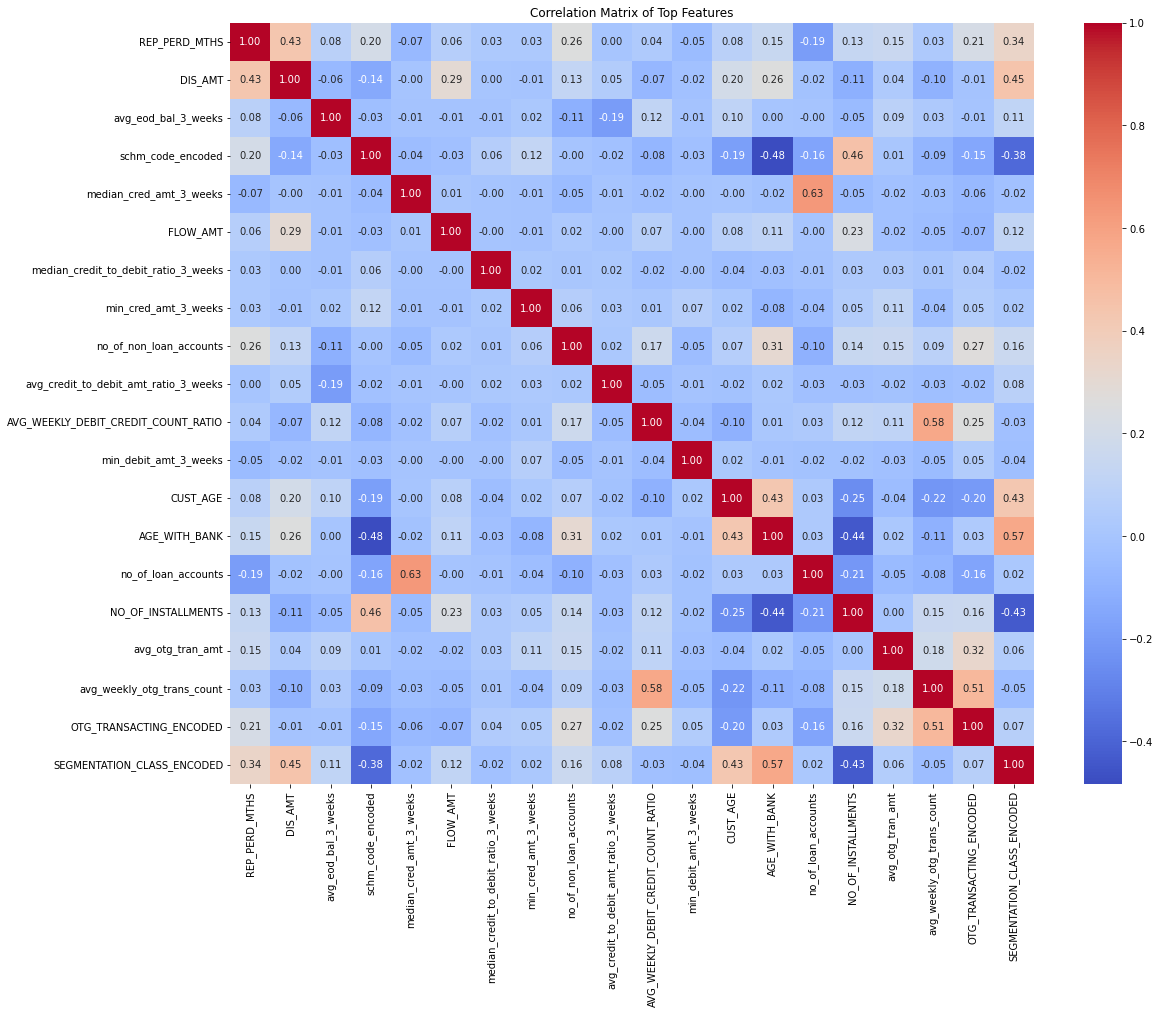

In [327]:
top_features = sorted_feature_importance.head(20).index

correlation_matrix = df_correct[top_features].corr()


plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix of Top Features")
plt.show()


In [328]:
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
top_correlations = upper_triangle.unstack().dropna().abs().sort_values(ascending=False).head(10)
print(top_correlations)


no_of_loan_accounts         median_cred_amt_3_weeks                0.6310804538000897
avg_weekly_otg_trans_count  AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO     0.576101919467566
SEGMENTATION_CLASS_ENCODED  AGE_WITH_BANK                          0.5740092309452345
OTG_TRANSACTING_ENCODED     avg_weekly_otg_trans_count             0.5068055062481839
AGE_WITH_BANK               schm_code_encoded                      0.4824333129178632
NO_OF_INSTALLMENTS          schm_code_encoded                     0.46023749241882816
SEGMENTATION_CLASS_ENCODED  DIS_AMT                               0.44862682489369865
NO_OF_INSTALLMENTS          AGE_WITH_BANK                          0.4387625442982076
DIS_AMT                     REP_PERD_MTHS                         0.43468835491116337
SEGMENTATION_CLASS_ENCODED  NO_OF_INSTALLMENTS                    0.43318485468337653
dtype: float64


In [330]:
numerical_columns = df_correct.select_dtypes(include=['int64', 'float64', 'uint64']).columns
numerical_columns = numerical_columns.drop('DEFAULT_STATUS_ENCODED')


In [329]:
df_correct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 0 to 41050
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CIF_ID                                 537 non-null    object 
 1   CUST_AGE                               537 non-null    int64  
 2   AGE_WITH_BANK                          537 non-null    int64  
 3   DIS_AMT                                537 non-null    float64
 4   REP_PERD_MTHS                          537 non-null    int64  
 5   FLOW_AMT                               537 non-null    float64
 6   NO_OF_INSTALLMENTS                     537 non-null    int64  
 7   min_debit_amt_3_weeks                  537 non-null    float64
 8   median_cred_amt_3_weeks                537 non-null    float64
 9   min_cred_amt_3_weeks                   537 non-null    float64
 10  avg_eod_bal_3_weeks                    537 non-null    float64
 11  AVG_

In [331]:
y_true = df_correct['DEFAULT_STATUS_ENCODED']

In [332]:
df2 = df_correct.copy()

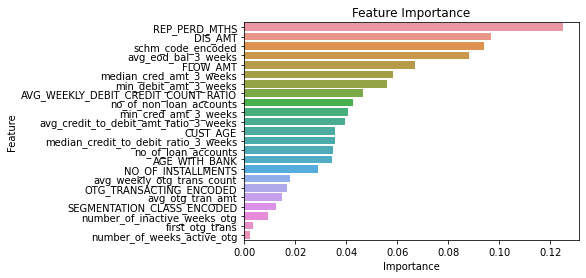

In [333]:
from sklearn.ensemble import RandomForestClassifier

X = df2[numerical_columns].fillna(0)
y = df2['DEFAULT_STATUS_ENCODED']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = rf.feature_importances_

features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=features)
plt.title('Feature Importance')
plt.show()


In [337]:
features.head(20)

,Feature,Importance
3,REP_PERD_MTHS,0.12493163009244075
2,DIS_AMT,0.09683117718817878
20,schm_code_encoded,0.09391515461783707
9,avg_eod_bal_3_weeks,0.08802479714778909
4,FLOW_AMT,0.06684225195312399
7,median_cred_amt_3_weeks,0.058149465369375354
6,min_debit_amt_3_weeks,0.05594168185989446
10,AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO,0.046633371578600355
12,no_of_non_loan_accounts,0.042817821406070086
8,min_cred_amt_3_weeks,0.04062752499866164


In [338]:
X = df2.drop(['DEFAULT_STATUS_ENCODED'], axis=1) 
y = df2['DEFAULT_STATUS_ENCODED'] 
top_features = features.head(20)['Feature'].tolist()

In [339]:
df2.DEFAULT_STATUS_ENCODED.value_counts()

0    478
1     59
Name: DEFAULT_STATUS_ENCODED, dtype: int64

In [354]:
df_majority = df2[df2.DEFAULT_STATUS_ENCODED == 0]
df_minority = df2[df2.DEFAULT_STATUS_ENCODED == 1]

df_majority_sampled = df_majority.sample(n=100, random_state=123)
df_minority_sampled = df_minority.sample(n=54, random_state=123)

df_sampled = pd.concat([df_majority_sampled, df_minority_sampled])

print(df_sampled.DEFAULT_STATUS_ENCODED.value_counts())

0    100
1     54
Name: DEFAULT_STATUS_ENCODED, dtype: int64


In [355]:
cif_ids = df_sampled['CIF_ID']

In [356]:
df_sampled.set_index('CIF_ID', inplace=True)

In [357]:
df_sampled.columns

Index(['CUST_AGE', 'AGE_WITH_BANK', 'DIS_AMT', 'REP_PERD_MTHS', 'FLOW_AMT',
       'NO_OF_INSTALLMENTS', 'min_debit_amt_3_weeks',
       'median_cred_amt_3_weeks', 'min_cred_amt_3_weeks',
       'avg_eod_bal_3_weeks', 'AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO',
       'no_of_loan_accounts', 'no_of_non_loan_accounts', 'first_otg_trans',
       'number_of_weeks_active_otg', 'avg_otg_tran_amt',
       'avg_weekly_otg_trans_count', 'number_of_inactive_weeks_otg',
       'avg_credit_to_debit_amt_ratio_3_weeks',
       'median_credit_to_debit_ratio_3_weeks', 'DEFAULT_STATUS_ENCODED',
       'schm_code_encoded', 'SEGMENTATION_CLASS_ENCODED',
       'OTG_TRANSACTING_ENCODED'],
      dtype='object')

In [358]:
df_sampled.fillna(0, inplace=True)
X_selected = df_sampled[top_features]
y_selected = df_sampled['DEFAULT_STATUS_ENCODED']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.20, random_state=42, stratify=y_selected)


In [359]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [360]:

y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9354838709677419
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.91      0.91      0.91        11

    accuracy                           0.94        31
   macro avg       0.93      0.93      0.93        31
weighted avg       0.94      0.94      0.94        31

[[19  1]
 [ 1 10]]


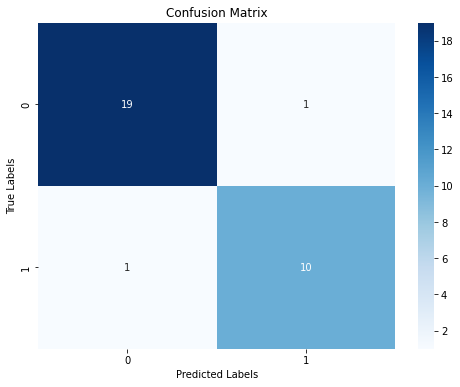

In [361]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [362]:
import pickle
filename = 'Nohyperparameter9.sav'
pickle.dump(rf_clf, open(filename, 'wb'))


# HYPERPARAMETER TUNING 

In [363]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 6),
    'class_weight': [{0: 0.4, 1: 0.6}, {0: 0.3, 1: 0.7}, {0: 0.2, 1: 0.8}],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_distributions, n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1, scoring='accuracy')

random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_}")


/Users/asha.anab/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asha.anab/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/asha.anab/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove thi

Best parameters: {'class_weight': {0: 0.2, 1: 0.8}, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 267}
Best CV score: 0.8383333333333333


In [365]:
rf_optimized = RandomForestClassifier(
    n_estimators=267,
    max_depth=7,
    min_samples_split=2,
    class_weight = {0: 0.2, 1: 0.8},
    min_samples_leaf=3,
    max_features= None,
    random_state=42
)


rf_optimized.fit(X_train, y_train)


y_pred_optimized = rf_optimized.predict(X_test)


accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
class_report_optimized = classification_report(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

print(f"Optimized Model Accuracy: {accuracy_optimized}")
print("Optimized Classification Report:")
print(class_report_optimized)
print("Optimized Confusion Matrix:")
print(conf_matrix_optimized)


Optimized Model Accuracy: 0.8709677419354839
Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        20
           1       0.77      0.91      0.83        11

    accuracy                           0.87        31
   macro avg       0.86      0.88      0.86        31
weighted avg       0.88      0.87      0.87        31

Optimized Confusion Matrix:
[[17  3]
 [ 1 10]]


In [351]:
df_sampled.fillna(0, inplace=True)
predictions = rf_optimized.predict(X_selected)
probabilities = rf_optimized.predict_proba(X_selected)


In [352]:
results = pd.DataFrame({
    'CIF_ID': cif_ids,
    'Predictions': predictions,
    'Probabilities': probabilities[:, 1],  
    #'y_true': y_true 
})

In [366]:
import pickle
filename = 'hyperperameterw3.sav'
pickle.dump(rf_optimized, open(filename, 'wb'))